In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import nltk

W0413 14:15:49.183737 140276500191104 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='train')

train_data = np.array(train.data)
test_data = np.array(test.data)
y_train = train.target
y_test = test.target

class_list = list(train.target_names)

In [0]:
from sklearn.metrics import roc_auc_score
def mean_roc_auc(y_true, y_pred):
    y = np.array(y_true.copy())
    probas = np.array(y_pred.copy())
    rs = []
    for i in range(len(class_list)):
        r = roc_auc_score((y==i).astype(int), probas[:, i])
        rs.append(r)
    return np.mean(rs)

In [0]:
maxlen = 400*5
def gen(texts, labels):
    for text, label in zip(texts, labels):
        yield np.array(tokens[:maxlen]), label

def input_fn(texts, labels, params, is_training):
    dataset = tf.data.Dataset.from_generator(lambda:gen(texts, labels), 
                                            (tf.string, tf.int32),
                                              output_shapes=(tf.TensorShape([]), tf.TensorShape([])))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(params['batch_size'])
    if is_training:
        dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [0]:
NUM_CLASSES = len(class_list)
head = tf.contrib.estimator.multi_class_head(NUM_CLASSES)

def create_model(features, params, is_training):
    def get_logits(x):
        embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2", trainable=False)
        embeddings = embed(x['text'])

        dropout_outputs = tf.layers.dropout(inputs=embeddings, 
                                         rate=0.2, 
                                         training=is_training)
        dense_1 = tf.layers.dense(dropout_outputs, 300)
        dense_2 = tf.layers.dense(dense_1, 100)
        model_output = tf.layers.dense(dense_2, params['num_labels'])
        return model_output
        
    with tf.variable_scope('encoder'):
        logits = get_logits(features)
    
    return logits

def model_fn(features, labels, mode, params): 
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    with tf.variable_scope('model'):
        logits = create_model(features, params, is_training)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        class_nums = tf.argmax(logits,1)
        probas = tf.nn.softmax(logits)
        predictions = {'y':class_nums, 'probas':probas}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    if mode ==  tf.estimator.ModeKeys.EVAL:
        probas = tf.nn.softmax(logits)
        aucs = []
        for i in range(len(class_list)):
            auc = tf.metrics.auc(labels, probas[:, i])
            aucs.append(auc)
        mean_auc = tf.reduce_mean(aucs)
        tf.summary.scalar('mean_auc', mean_auc)
#         metrics = {'mean_auc': mean_auc}
        loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss)
    
    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)


In [0]:
params = {
         'num_labels': len(class_list),
         'batch_size': 4}

def get_part_of_data(data, y, count_per_class):
    new_data = []
    new_labels = []
    for label, _ in enumerate(class_list):
        idxs = np.where(y==label)[0]
        idxs = np.random.choice(idxs, count_per_class).astype(int)
        new_data.extend([_ for _ in data[idxs]])
        new_labels.extend([_ for _ in y[idxs]])
    return {'text': np.array(new_data)}, np.array(new_labels)

In [0]:
! rm -r uni_exp_12

In [48]:

aucs = []
for count_examples in range(12,20):
    model_dir = f'uni_exp_{count_examples}'
    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       model_dir=model_dir,
                                       params=params)
    c_steps = int((count_examples*len(class_list)/params['batch_size'])*2)

    new_train_data, new_y_train = get_part_of_data(train_data, y_train, count_examples)
    estimator.train(input_fn=tf.estimator.inputs.numpy_input_fn(new_train_data, new_y_train, shuffle=False))
    #estimator.train(input_fn=lambda: input_fn(train_data, y_train, params, is_training=True), steps=c_steps)
    
    new_test_data, new_y_test = get_part_of_data(test_data, y_test, 20)
    y_pred = estimator.predict(input_fn=tf.estimator.inputs.numpy_input_fn(new_test_data, new_y_test, shuffle=False))
    y_pred = [_ for _ in tqdm(y_pred)]

    auc = mean_roc_auc(new_y_test, [_['probas'] for _ in y_pred])
    print(f'{count_examples}-{auc}')
    aucs.append(auc)

INFO:tensorflow:Using default config.


I0413 15:06:56.843904 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9458a51198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:06:56.855669 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9458a51198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:06:57.005402 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:06:58.860889 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:07:00.532983 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:07:01.039079 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:07:01.041417 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:07:01.266428 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:07:03.163220 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:07:10.067631 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_12/model.ckpt.


I0413 15:07:25.933058 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_12/model.ckpt.


INFO:tensorflow:loss = 3.0147767, step = 1


I0413 15:07:35.363353 140276500191104 basic_session_run_hooks.py:249] loss = 3.0147767, step = 1


INFO:tensorflow:Saving checkpoints for 2 into uni_exp_12/model.ckpt.


I0413 15:07:36.854107 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 2 into uni_exp_12/model.ckpt.


INFO:tensorflow:Loss for final step: 3.0278194.


I0413 15:08:03.842660 140276500191104 estimator.py:359] Loss for final step: 3.0278194.


INFO:tensorflow:Calling model_fn.


I0413 15:08:04.153166 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:08:05.973989 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:08:07.794385 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:08:08.083449 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:08:08.269263 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_12/model.ckpt-2


I0413 15:08:08.280881 140276500191104 saver.py:1270] Restoring parameters from uni_exp_12/model.ckpt-2


INFO:tensorflow:Running local_init_op.


I0413 15:08:47.294597 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:08:54.479907 140276500191104 session_manager.py:493] Done running local_init_op.



12-0.7171578947368421
INFO:tensorflow:Using default config.


I0413 15:08:58.583101 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9461fc9048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:08:58.586008 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9461fc9048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:08:58.751194 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:09:00.592979 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:09:02.456233 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:09:03.056129 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:09:03.058513 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:09:05.883237 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:09:44.923677 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:09:51.525412 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_13/model.ckpt.


I0413 15:10:06.650777 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_13/model.ckpt.


INFO:tensorflow:loss = 3.0120163, step = 1


I0413 15:10:16.351785 140276500191104 basic_session_run_hooks.py:249] loss = 3.0120163, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_13/model.ckpt.


I0413 15:10:17.906785 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_13/model.ckpt.


INFO:tensorflow:Loss for final step: 3.0849907.


I0413 15:10:43.664891 140276500191104 estimator.py:359] Loss for final step: 3.0849907.


INFO:tensorflow:Calling model_fn.


I0413 15:10:43.950523 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:10:46.265741 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:10:47.879793 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:10:48.175727 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:10:48.356248 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_13/model.ckpt-3


I0413 15:10:48.379078 140276500191104 saver.py:1270] Restoring parameters from uni_exp_13/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:11:27.319754 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:11:33.592885 140276500191104 session_manager.py:493] Done running local_init_op.



13-0.7841447368421053
INFO:tensorflow:Using default config.


I0413 15:11:37.107899 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f949fec57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:11:37.117828 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f949fec57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:11:37.282301 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:11:39.283326 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:11:41.088707 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:11:41.633836 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:11:41.636311 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:11:44.500120 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:12:23.482410 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:12:29.573643 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_14/model.ckpt.


I0413 15:12:44.523614 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_14/model.ckpt.


INFO:tensorflow:loss = 3.0023422, step = 1


I0413 15:12:54.639512 140276500191104 basic_session_run_hooks.py:249] loss = 3.0023422, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_14/model.ckpt.


I0413 15:12:55.508882 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_14/model.ckpt.


INFO:tensorflow:Loss for final step: 3.1239662.


I0413 15:13:21.650465 140276500191104 estimator.py:359] Loss for final step: 3.1239662.


INFO:tensorflow:Calling model_fn.


I0413 15:13:21.934149 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:13:24.376648 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:13:26.161242 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:13:26.475455 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:13:26.658458 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_14/model.ckpt-3


I0413 15:13:26.666623 140276500191104 saver.py:1270] Restoring parameters from uni_exp_14/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:14:05.598212 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:14:11.943544 140276500191104 session_manager.py:493] Done running local_init_op.



14-0.7965592105263158
INFO:tensorflow:Using default config.


I0413 15:14:16.347516 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f945fd4aef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:14:16.354907 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f945fd4aef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:14:16.510744 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:14:18.762327 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:14:20.471711 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:14:21.045024 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:14:21.048995 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:14:23.983255 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:15:03.080527 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:15:09.658816 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_15/model.ckpt.


I0413 15:15:26.095376 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_15/model.ckpt.


INFO:tensorflow:loss = 2.9926095, step = 1


I0413 15:15:36.730477 140276500191104 basic_session_run_hooks.py:249] loss = 2.9926095, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_15/model.ckpt.


I0413 15:15:38.008833 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_15/model.ckpt.


INFO:tensorflow:Loss for final step: 3.1064432.


I0413 15:16:02.725102 140276500191104 estimator.py:359] Loss for final step: 3.1064432.


INFO:tensorflow:Calling model_fn.


I0413 15:16:03.034701 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:16:05.284275 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:16:07.133586 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:16:07.463916 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:16:07.669639 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_15/model.ckpt-3


I0413 15:16:07.678294 140276500191104 saver.py:1270] Restoring parameters from uni_exp_15/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:16:46.999888 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:16:53.944265 140276500191104 session_manager.py:493] Done running local_init_op.



15-0.7795657894736843
INFO:tensorflow:Using default config.


I0413 15:16:58.623853 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946120b860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:16:58.635442 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946120b860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:16:58.817638 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:17:00.027626 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:17:02.268263 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:17:02.833336 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:17:02.837817 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:17:05.653599 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:17:44.513403 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:17:50.997323 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_16/model.ckpt.


I0413 15:18:08.155321 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_16/model.ckpt.


INFO:tensorflow:loss = 2.988699, step = 1


I0413 15:18:18.883254 140276500191104 basic_session_run_hooks.py:249] loss = 2.988699, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_16/model.ckpt.


I0413 15:18:20.723844 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_16/model.ckpt.


INFO:tensorflow:Loss for final step: 3.1509805.


I0413 15:18:45.388877 140276500191104 estimator.py:359] Loss for final step: 3.1509805.


INFO:tensorflow:Calling model_fn.


I0413 15:18:45.686822 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:18:46.948155 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:18:49.135902 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:18:49.459263 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:18:49.666099 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_16/model.ckpt-3


I0413 15:18:49.676019 140276500191104 saver.py:1270] Restoring parameters from uni_exp_16/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:19:28.796850 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:19:35.431695 140276500191104 session_manager.py:493] Done running local_init_op.



16-0.7860394736842106
INFO:tensorflow:Using default config.


I0413 15:19:39.070564 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f945d5c82e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:19:39.073260 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f945d5c82e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:19:39.255063 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:19:41.308227 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:19:42.969473 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:19:43.499513 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:19:43.501766 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:19:46.198018 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:20:25.285679 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:20:32.203094 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_17/model.ckpt.


I0413 15:20:49.160431 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_17/model.ckpt.


INFO:tensorflow:loss = 2.9988837, step = 1


I0413 15:20:59.847574 140276500191104 basic_session_run_hooks.py:249] loss = 2.9988837, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_17/model.ckpt.


I0413 15:21:01.053774 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_17/model.ckpt.


INFO:tensorflow:Loss for final step: 3.072537.


I0413 15:21:25.417309 140276500191104 estimator.py:359] Loss for final step: 3.072537.


INFO:tensorflow:Calling model_fn.


I0413 15:21:25.678552 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:21:27.762268 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:21:29.556843 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:21:29.845686 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:21:30.026949 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_17/model.ckpt-3


I0413 15:21:30.040754 140276500191104 saver.py:1270] Restoring parameters from uni_exp_17/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:22:08.970335 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:22:15.667560 140276500191104 session_manager.py:493] Done running local_init_op.



17-0.7698289473684211
INFO:tensorflow:Using default config.


I0413 15:22:20.306584 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946190e748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:22:20.320232 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946190e748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:22:20.546740 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:22:22.822369 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:22:24.310175 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:22:25.215428 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:22:25.217904 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:22:28.080942 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:23:07.151686 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:23:14.037581 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_18/model.ckpt.


I0413 15:23:30.155064 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_18/model.ckpt.


INFO:tensorflow:loss = 3.0030138, step = 1


I0413 15:23:39.642443 140276500191104 basic_session_run_hooks.py:249] loss = 3.0030138, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_18/model.ckpt.


I0413 15:23:41.631986 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_18/model.ckpt.


INFO:tensorflow:Loss for final step: 3.0644495.


I0413 15:24:07.449146 140276500191104 estimator.py:359] Loss for final step: 3.0644495.


INFO:tensorflow:Calling model_fn.


I0413 15:24:07.756769 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:24:09.756687 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:24:11.200682 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:24:11.538993 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:24:12.080477 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_18/model.ckpt-3


I0413 15:24:12.088081 140276500191104 saver.py:1270] Restoring parameters from uni_exp_18/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:24:51.072211 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:24:57.707827 140276500191104 session_manager.py:493] Done running local_init_op.



18-0.7945263157894737
INFO:tensorflow:Using default config.


I0413 15:25:02.060364 140276500191104 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'uni_exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946731d898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 15:25:02.067648 140276500191104 estimator.py:201] Using config: {'_model_dir': 'uni_exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f946731d898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 15:25:02.310570 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:25:03.960380 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:25:06.184135 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:25:06.714563 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 15:25:06.717270 140276500191104 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 15:25:09.484083 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 15:25:48.467881 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:25:54.904541 140276500191104 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into uni_exp_19/model.ckpt.


I0413 15:26:10.697350 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 0 into uni_exp_19/model.ckpt.


INFO:tensorflow:loss = 2.9764702, step = 1


I0413 15:26:21.087205 140276500191104 basic_session_run_hooks.py:249] loss = 2.9764702, step = 1


INFO:tensorflow:Saving checkpoints for 3 into uni_exp_19/model.ckpt.


I0413 15:26:23.070926 140276500191104 basic_session_run_hooks.py:594] Saving checkpoints for 3 into uni_exp_19/model.ckpt.


INFO:tensorflow:Loss for final step: 3.1180096.


I0413 15:26:47.354703 140276500191104 estimator.py:359] Loss for final step: 3.1180096.


INFO:tensorflow:Calling model_fn.


I0413 15:26:47.651039 140276500191104 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:26:49.567351 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 15:26:51.360250 140276500191104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 15:26:51.696179 140276500191104 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 15:26:51.904034 140276500191104 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from uni_exp_19/model.ckpt-3


I0413 15:26:51.909390 140276500191104 saver.py:1270] Restoring parameters from uni_exp_19/model.ckpt-3


INFO:tensorflow:Running local_init_op.


I0413 15:27:30.952839 140276500191104 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 15:27:38.225512 140276500191104 session_manager.py:493] Done running local_init_op.



19-0.8020855263157894


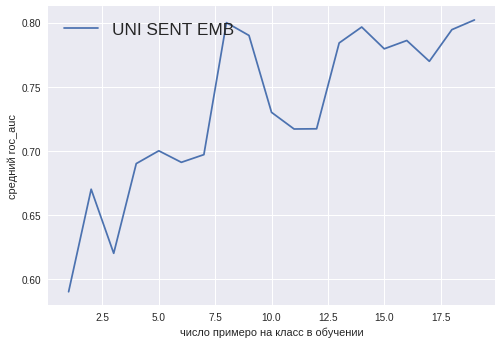

In [50]:
plt.plot(list(range(1,20)), aucs, label='UNI SENT EMB')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('число примеро на класс в обучении')
plt.ylabel('средний roc_auc')
plt.show()